## CutMix, Mixup exp
- 초기 실험 중요
  - 얼마나 걸리는지.. 등..을 확인 후에, **자원을 효율적으로 사용**하기 위하여 초기 실험의 환경을 설정해야 함
  - 뭘 먼저 확인할 건지 우선 순위 설정도 해야 함
- 오버피팅 지점이 어디..? -> 각 모델의 오버피팅을 확인해야함
- 테스트 데이터를 이용해서 진짜 잘 나오는지 확인
  - 오버피팅 전 && 최적화 모델
- 중간 중간 기록하기
- Training loss와 validation accuracy 비교
- 그래프를 세로로 놓으면 에폭을 비교하기 편함

### 1. Augmentation을 적용한 데이터셋 만들기

In [1]:
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import os

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

### **Cutmix Augmentation**

In [5]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [6]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [7]:
# mix two labels
# def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120): # parameter undefined
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [8]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### **Mixup Augmentation**

In [9]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [10]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### **augmentations을 적용하는 함수**

In [11]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, additional_aug=None):
    # 코드 가독성이 떨어져서 is_train 변수 추가
    is_train = not is_test
    
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)

    if is_train and with_aug:
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)

    if is_train and additional_aug != None:
        assert additional_aug in {'cutmix', 'mixup'}, \
            f"Invalid additional_aug value: {additional_aug}. Must be 'cutmix' or 'mixup'."
        
        aug_methods = {
            'cutmix': cutmix,
            'mixup': mixup
        }
        
        ds = ds.map(
            aug_methods[additional_aug],
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if is_train:
        ds = ds.repeat()
        ds = ds.shuffle(200)

    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

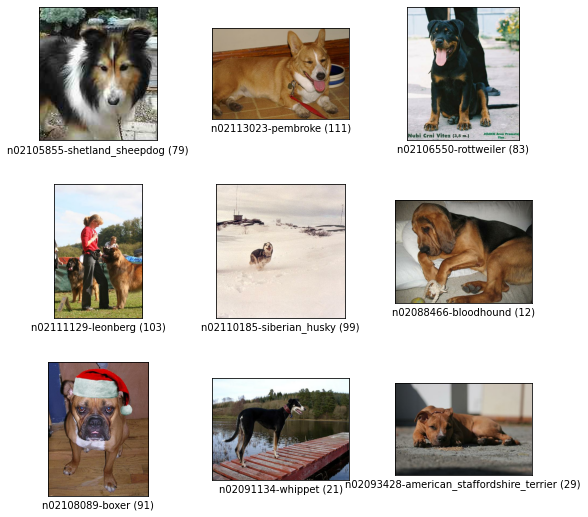

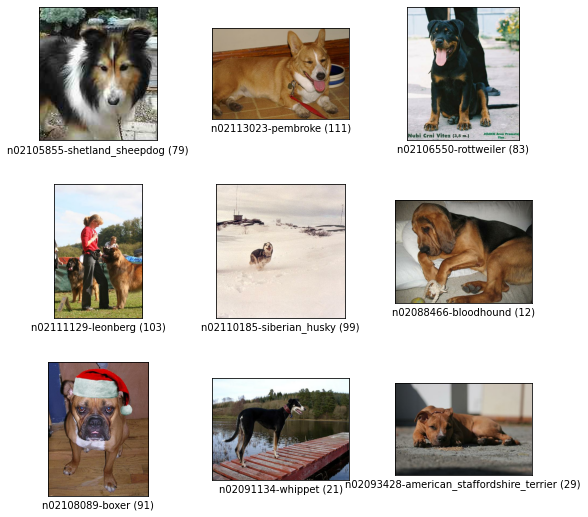

In [13]:
tfds.show_examples(ds_train, ds_info)

In [14]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='/aiffel/tensorflow_datasets/stanford_dogs/0.2.0',
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature

In [15]:
num_classes = ds_info.features["label"].num_classes

In [ ]:
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, additional_aug='mixup')
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, additional_aug='cutmix')
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [17]:
import matplotlib.pyplot as plt

def plt_image_from_dataset(ds):
    image_aug, label_aug = next(iter(ds))
    plt.imshow(image_aug[0])
    plt.show()
    
    print(label_aug[0])

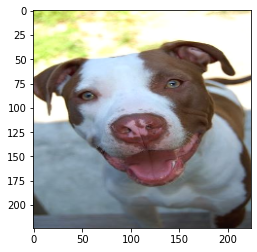

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(120,), dtype=float32)


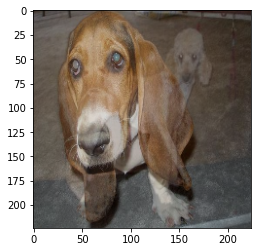

tf.Tensor(
[0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.664122 0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.335878 0.       0.   

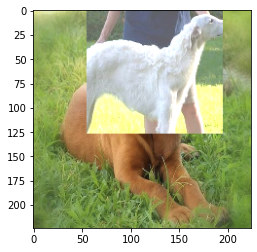

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.6456473  0.         0.         0.         0.         0.
 0.35435268 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [18]:
plt_image_from_dataset(ds_train_aug)
plt_image_from_dataset(ds_train_mixup)
plt_image_from_dataset(ds_train_cutmix)

### 2. 모델 만들기

In [19]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 3. 모델 훈련하기
- categorical_crossentropy() 손실 함수 사용

In [22]:
def visualize_history(history, title):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

#### 3.3 기본 Augmentation
- 일단 augmentation 없이 초기 모델이 epoch 7에서 training accuracy가 1이 됐으니 20 epochs만 돌려보자

In [23]:
EPOCH_AUG=20

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

checkpoint_path_aug = os.getenv('HOME')+'/aiffel/data_augmentation/checkpoint/aug_checkpoint.weights.h5'
model_checkpoint_aug = ModelCheckpoint(
    checkpoint_path_aug,
    save_weights_only=True, 
    monitor='val_loss',
    save_best_only=True,
    verbose=1)


history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH_AUG,
    callbacks=[model_checkpoint_aug],
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 165s 203ms/step - loss: 2.2904 - accuracy: 0.4240 - val_loss: 3.0606 - val_accuracy: 0.2491

Epoch 00001: val_loss improved from inf to 3.06057, saving model to /aiffel/aiffel/data_augmentation/checkpoint/aug_checkpoint.weights.h5
Epoch 2/20
750/750 [==============================] - 151s 202ms/step - loss: 0.9300 - accuracy: 0.7366 - val_loss: 1.2019 - val_accuracy: 0.6475

Epoch 00002: val_loss improved from 3.06057 to 1.20193, saving model to /aiffel/aiffel/data_augmentation/checkpoint/aug_checkpoint.weights.h5
Epoch 3/20
750/750 [==============================] - 151s 202ms/step - loss: 0.4813 - accuracy: 0.8686 - val_loss: 1.0836 - val_accuracy: 0.6803

Epoch 00003: val_loss improved from 1.20193 to 1.08364, saving model to /aiffel/aiffel/data_augmentation/checkpoint/aug_checkpoint.weights.h5
Epoch 4/20
750/750 [==============================] - 151s 202ms/step - loss: 0.2487 - accuracy: 0.9446 - val_loss: 1.0904 - val_accuracy

### 4. 훈련 과정 시각화하기
- 히스토리를 그래프로 시각화

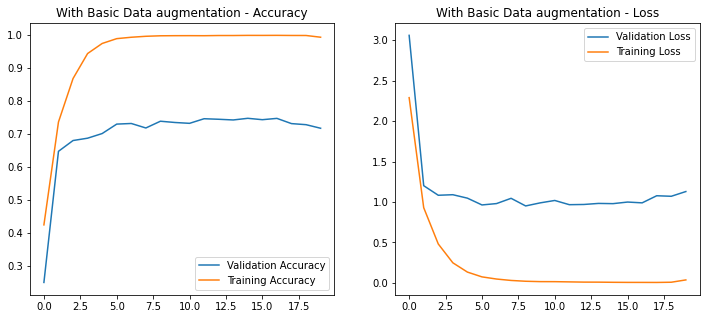

In [24]:
visualize_history(history_resnet50_aug, "With Basic Data augmentation")

In [25]:
import pandas as pd
his = history_resnet50_aug.history
df = pd.DataFrame(his)
df

,loss,accuracy,val_loss,val_accuracy
0,2.290420,0.424000,3.060570,0.249067
1,0.930049,0.736583,1.201931,0.647505
2,0.481346,0.868583,1.083640,0.680270
3,0.248702,0.944583,1.090407,0.687383
4,0.133937,0.975167,1.047922,0.701493
5,0.074636,0.989833,0.963983,0.730177
6,0.047933,0.994083,0.980825,0.732043
7,0.030485,0.997000,1.045909,0.718400
8,0.020505,0.998500,0.951584,0.738923
9,0.016003,0.998833,0.989640,0.735075


In [28]:
import pandas as pd

def save_history_to_csv_path(history, csv_path):
    history_data = history.history
    df = pd.DataFrame(history_data)
    df.to_csv(csv_path, index=False)

In [30]:
history_resnet50_aug_csv_path = os.getenv('HOME')+'/aiffel/data_augmentation/history/history_resnet50_aug.csv'
save_history_to_csv_path(history_resnet50_aug, history_resnet50_aug_csv_path)

df_loaded = pd.read_csv(history_resnet50_aug_csv_path)
df_loaded

,loss,accuracy,val_loss,val_accuracy
0,2.290420,0.424000,3.060570,0.249067
1,0.930049,0.736583,1.201931,0.647505
2,0.481346,0.868583,1.083640,0.680270
3,0.248702,0.944583,1.090407,0.687383
4,0.133937,0.975167,1.047922,0.701493
5,0.074636,0.989833,0.963983,0.730177
6,0.047933,0.994083,0.980825,0.732043
7,0.030485,0.997000,1.045909,0.718400
8,0.020505,0.998500,0.951584,0.738923
9,0.016003,0.998833,0.989640,0.735075
